In [ ]:
#Reference: SimpleITK documentation: https://simpleitk.readthedocs.io/en/master/

In [1]:
import SimpleITK as sitk
from downloaddata import fetch_data as fdata
%matplotlib notebook
import gui
import registration_gui as rgui

import numpy as np
import os
OUTPUT_DIR = 'output'

In [2]:
fixed_image =  sitk.ReadImage("/Users/pronomabanerjee/Desktop/subvolumes_abdomen/cryocleaned_abdomen_padded.mhd", sitk.sitkFloat32)
#moving_image = sitk.ReadImage("/Users/pronomabanerjee/Desktop/subvolumes_abdomen/CT_abdomen.mhd", sitk.sitkFloat32)
moving_image = sitk.ReadImage("/Users/pronomabanerjee/Desktop/subvolumes_abdomen/TUTORIAL/output/MRI_transformed_SITK1.mhd", sitk.sitkFloat32)

ct_window_level = [835,162]
mr_window_level = [1036,520]

gui.MultiImageDisplay(image_list = [fixed_image, moving_image],                   
                      title_list = ['fixed', 'moving'], figure_size=(8,4), window_level_list=[ct_window_level, mr_window_level]);

<IPython.core.display.Javascript object>

In [8]:
def command_iteration(filter):
    print(f"{filter.GetElapsedIterations():3} = {filter.GetMetric():10.5f}")


'''if len(sys.argv) < 4:
    print(
        f"Usage: {sys.argv[0]} <fixedImageFilter> <movingImageFile> <outputTransformFile>")
    sys.exit(1)'''

fixed = fixed_image

moving = moving_image

matcher = sitk.HistogramMatchingImageFilter()
matcher.SetNumberOfHistogramLevels(1024)
matcher.SetNumberOfMatchPoints(7)
matcher.ThresholdAtMeanIntensityOn()
moving = matcher.Execute(moving, fixed)

# The basic Demons Registration Filter
# Note there is a whole family of Demons Registration algorithms included in
# SimpleITK
#demons = sitk.DemonsRegistrationFilter()
#demons = sitk.DiffeomorphicDemonsRegistrationFilter()
#demons = sitk.FastSymmetricForcesDemonsRegistrationFilter()
demons = sitk.SymmetricForcesDemonsRegistrationFilter()
demons.SetNumberOfIterations(50)
# Standard deviation for Gaussian smoothing of displacement field
demons.SetStandardDeviations(1.0)

demons.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(demons))

displacementField = demons.Execute(fixed, moving)

print("-------")
print(f"Number Of Iterations: {demons.GetElapsedIterations()}")
print(f" RMS: {demons.GetRMSChange()}")

outTx = sitk.DisplacementFieldTransform(displacementField)

sitk.WriteTransform(outTx, os.path.join(OUTPUT_DIR, "detailsdeformsfdemonsmri.tfm"))

  1 = 1487.76152
  2 = 1355.60348
  3 = 1282.24001
  4 = 1230.30827
  5 = 1195.53789
  6 = 1168.30414
  7 = 1146.08239
  8 = 1126.69088
  9 = 1109.83707
 10 = 1095.26491
 11 = 1082.28623
 12 = 1071.36391
 13 = 1061.01931
 14 = 1051.74386
 15 = 1042.92870
 16 = 1034.91467
 17 = 1027.52825
 18 = 1020.68700
 19 = 1014.45789
 20 = 1008.60352
 21 = 1003.09017
 22 =  997.93368
 23 =  993.12344
 24 =  988.42960
 25 =  984.07202
 26 =  979.78488
 27 =  975.91544
 28 =  972.12940
 29 =  968.70165
 30 =  965.22976
 31 =  962.14354
 32 =  958.98627
 33 =  956.13988
 34 =  953.14014
 35 =  950.46661
 36 =  947.72848
 37 =  945.36011
 38 =  942.82801
 39 =  940.57929
 40 =  938.12812
 41 =  936.14444
 42 =  933.97357
 43 =  932.20951
 44 =  930.12569
 45 =  928.46561
 46 =  926.49870
 47 =  924.78562
 48 =  922.96875
 49 =  921.43219
 50 =  919.67759
-------
Number Of Iterations: 50
 RMS: 0.5223684369785287


In [9]:
if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    #simg1 = sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    # Use the // floor division operator so that the pixel type is
    # the same for all three images which is the expectation for
    # the compose filter.
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)

<IPython.core.display.Javascript object>


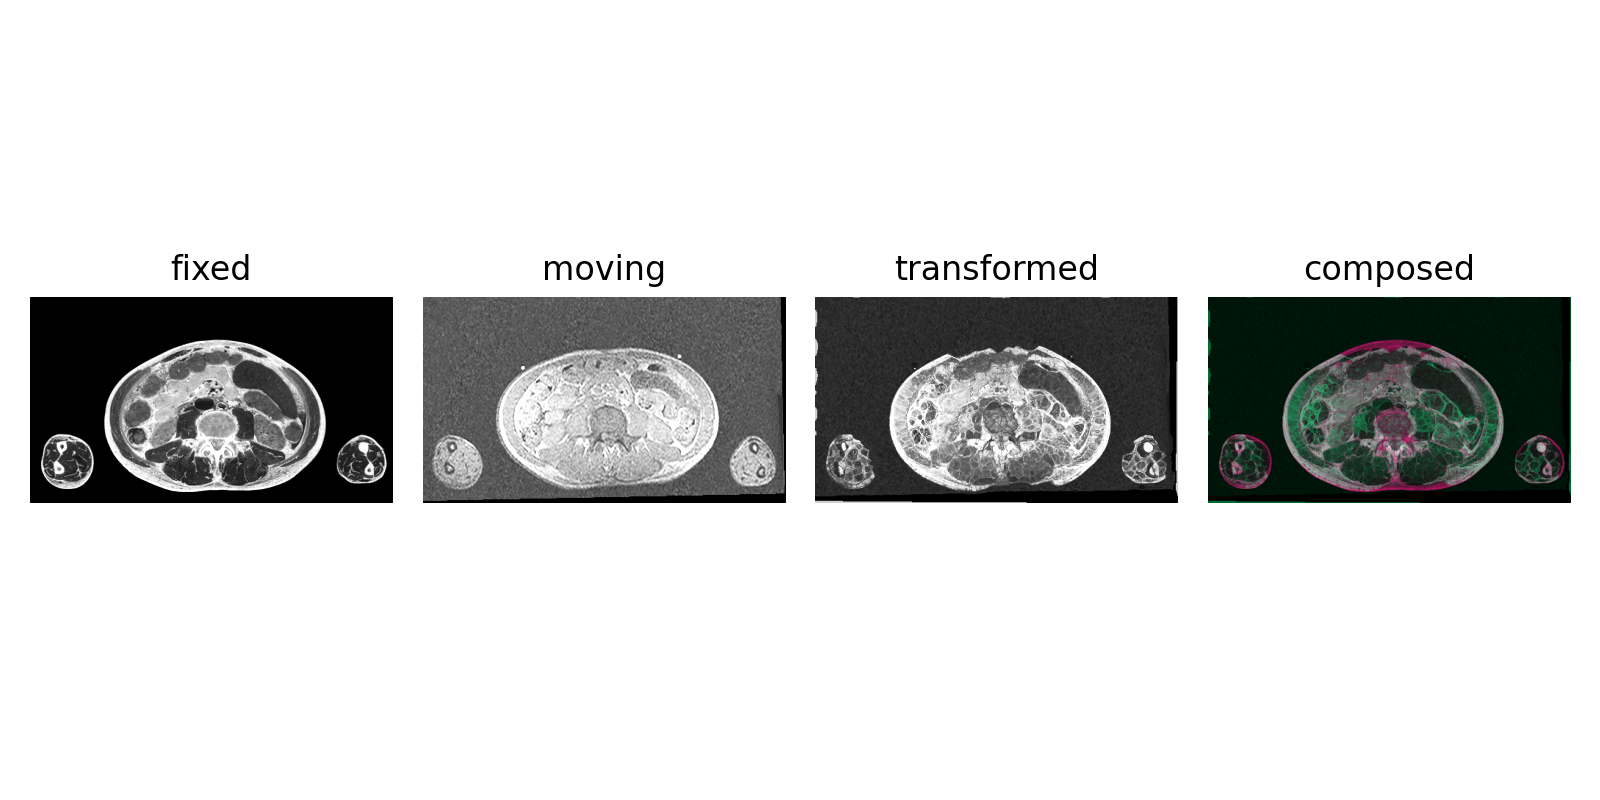

<IPython.core.display.Javascript object>


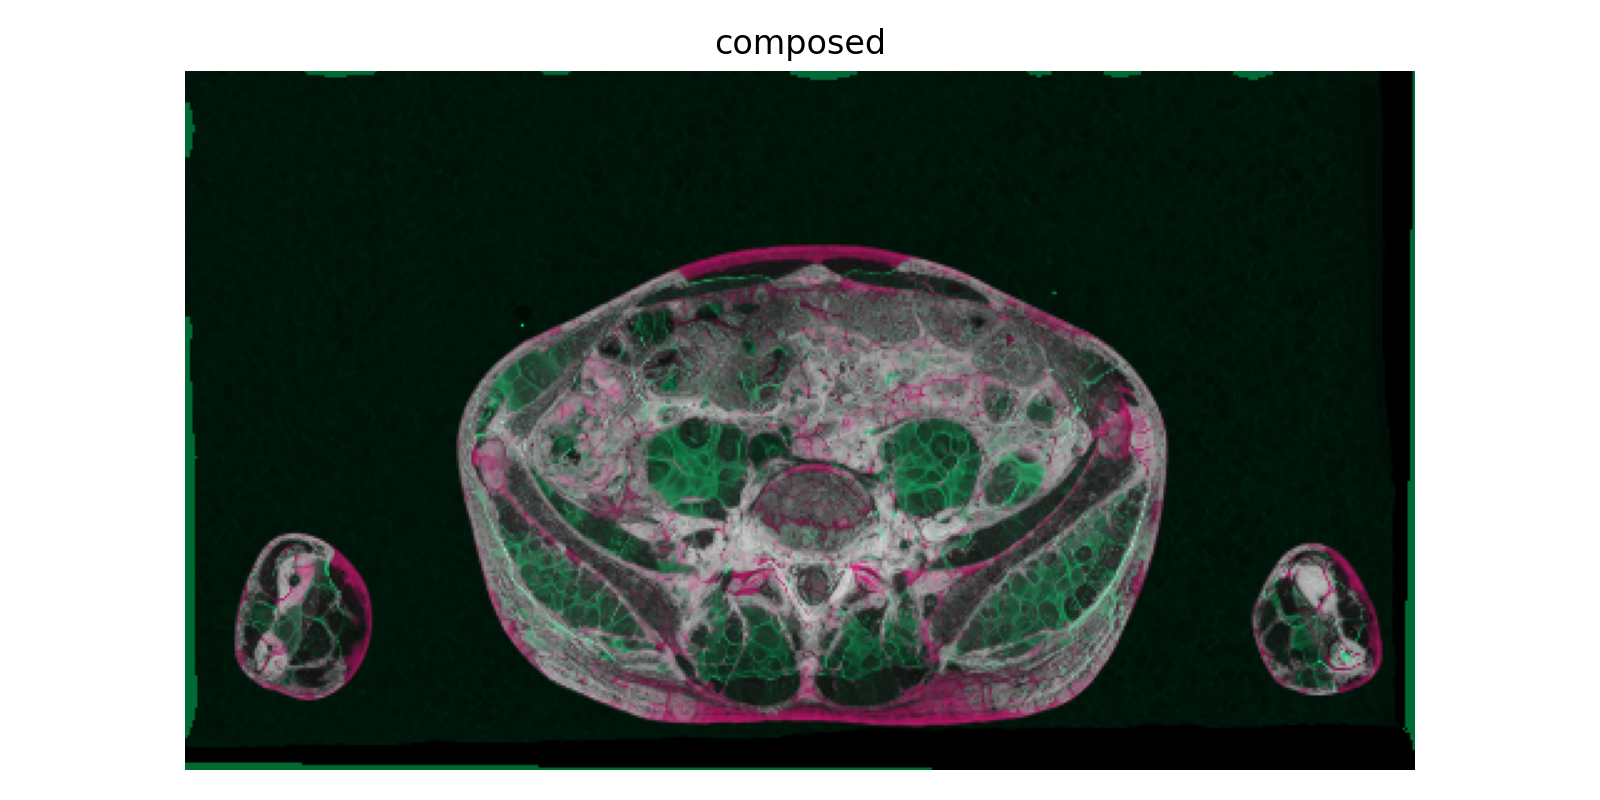

In [13]:
gui.MultiImageDisplay(image_list = [fixed_image, moving_image, out, cimg],                   
                      title_list = ['fixed', 'moving', 'transformed', 'composed'], figure_size=(8,4));


gui.MultiImageDisplay(image_list = [cimg],                   
                      title_list = ['composed'], figure_size=(8,4));



In [11]:
sitk.WriteImage(out, os.path.join(OUTPUT_DIR, "MRI_sfdemons.mhd"))